In [2]:
import pandas as pd
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_context('poster')
sns.set_style('white')

# Statistics in Measurement

Questions to answer:

1. What is the interpretation of a 95% confidence interval?
1. What is the interpretation of a 95% highest posterior density interval?
1. How are they related?
1. Can we be more interpretable?

# References

1. John Kruschke: [Precision is the Goal](https://www.youtube.com/watch?v=lh5btlAvrLs)
1. John Kruschke: [Bayesian Estimation Supersedes the t-Test](http://www.indiana.edu/~kruschke/BEST/)
1. PyMC3 implementation: [Bayesian Estimation Supersedes the t-Test](https://pymc-devs.github.io/pymc3/notebooks/BEST.html)

This work here extends John Kruschke's implementation.

In [3]:
baseline_name = 'Water'

data = pd.read_csv('bandoro-microbiome.csv')

# Encode the "Sample" column with indices.
sample_names = dict()
for i, name in enumerate(sorted(np.unique(data['Sample'].values))):
    sample_names[name] = i

for name, i in sample_names.items():
    data['Indices'] = data['Sample'].apply(lambda x: sample_names[x])
    
data = data.sort_values(by='Indices')
data = data.reset_index(drop=True)
    
baseline_idx = sample_names[baseline_name]
indices = list(set(data['Indices']))
indices.remove(baseline_idx)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [4]:
data.tail(20)

,Date,Sample,% GFP,Normalized % GFP,Replicate,Indices
36,09.03.2016,Parabacteroides distastonis,9.06,55.925926,2,9
37,08.31.2016,Parabacteroides distastonis,20.20,84.342380,3,9
38,08.31.2016,Parabacteroides distastonis,20.40,85.177453,4,9
39,09.03.2016,Parabacteroides distastonis,8.84,54.567901,1,9
40,09.03.2016,Pseudomonas aeruginosa,5.49,33.888889,2,10
41,08.31.2016,Pseudomonas aeruginosa,11.60,48.434238,3,10
42,08.31.2016,Pseudomonas aeruginosa,13.30,55.532359,4,10
43,09.03.2016,Pseudomonas aeruginosa,5.73,35.370370,1,10
44,08.31.2016,Rumincoccus obeum,14.20,59.290188,4,11
45,08.31.2016,Rumincoccus obeum,15.10,63.048017,3,11


In [5]:
summary_stats = pd.DataFrame()
summary_stats['mean'] = data.groupby('Sample').mean()['Normalized % GFP']
# We want the total width of the uncertainty measure, so we multiply the stdev by 2.
summary_stats['std'] = data.groupby('Sample').std()['Normalized % GFP'] * 2
summary_stats['3sd'] = summary_stats['std'] * 3
summary_stats['sem'] = summary_stats['std'] / np.sqrt(4)
summary_stats['95ci'] = 1.96 * summary_stats['sem']
summary_stats['range'] = data.groupby('Sample').max()['Normalized % GFP'] - data.groupby('Sample').min()['Normalized % GFP']
summary_stats

,mean,std,3sd,sem,95ci,range
Sample,,,,,,
Akkermansia muciniphilia,78.277791,20.996487,62.989461,10.498243,20.576557,22.340782
Bacteroides fragilis,45.460869,3.525560,10.576681,1.762780,3.455049,3.757829
Bacteroides ovatus,87.525871,52.880332,158.640996,26.440166,51.822725,51.990644
Bacteroides thetaiotaomicron,66.386376,21.101564,63.304691,10.550782,20.679532,20.933400
Bacteroides vulgatus,56.403161,22.001431,66.004293,11.000716,21.561402,23.505116
Clostridium scindens,68.996463,25.432097,76.296291,12.716048,24.923455,30.555556
Escherichia coli BC15,35.287830,13.841571,41.524714,6.920786,13.564740,16.557386
Escherichia coli K12,55.125068,35.645586,106.936758,17.822793,34.932674,36.405062
Eubacterium rectale,66.034047,27.507662,82.522986,13.753831,26.957509,25.675404


What is the interpretation of the 95% confidence interval?

It isn't this:

> there's a 95% probability that the true value lies in the confidence interval. 

This statement is wrong because that isn't what the confidence tells us. Once the measurements are done, the true value is either inside or not; there is no probability. 

It is this:

> if the experiment were to be repeated again 100 times, with the same sample size, but with another random sample, we can expect 95 of them to contain the true population parameter.

This isn't particularly helpful or intuitive, even though it's been the guiding rule of statistical analysis of experimental data. Also, where does our computed bounds come into play here?

# Bayesian Thinking

By going Bayesian, we can ask about the *credibility* of a parameter that we're estimating.

In [6]:
with pm.Model() as model:
    # Hyperpriors
    upper = pm.Exponential('upper', lam=0.05)
    # nu_inv = pm.Uniform('nu', lower=1E-10, upper=0.5, shape=len(sample_names))
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1

    # "fold", which is the estimated fold change.
    fold = pm.Uniform('fold', lower=1E-10, upper=upper, shape=len(sample_names))

    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    # sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+2)
    sigma = pm.HalfCauchy('sigma', beta=1, shape=len(sample_names))

    # Model prediction
    mu = fold[data['Indices']]
    sig = sigma[data['Indices']]
    # nu_model = nu[data['Indices']]
    
    # Data likelihood
    like = pm.StudentT('like', nu=nu, mu=mu, sd=sig**-2, observed=data['Normalized % GFP'])    
    # like = pm.Normal('like', mu=mu, sd=sig, observed=data['Normalized % GFP'])
    
    diffs = pm.Deterministic('diffs', fold[indices] - fold[baseline_idx])
    s_pooled = pm.Deterministic('s_pooled', np.sqrt((sigma[indices] ** 2 + sigma[baseline_idx] ** 2) / 2))
    effect_size = pm.Deterministic('effect_size', diffs / s_pooled)
    
    # z_factor = pm.Deterministic('z_factor', 1 - (3 * sigma[indices, :] + 3 * sigma[baseline_idx]) / np.abs(fold[indices, :] - fold[baseline_idx]))

Applied log-transform to upper and added transformed upper_log_ to model.
Applied log-transform to nu_minus_one and added transformed nu_minus_one_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [7]:
with model:
    n_steps = 200000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -6511.92
Iteration 20000 [10%]: Average ELBO = -673.47
Iteration 40000 [20%]: Average ELBO = -281.37
Iteration 60000 [30%]: Average ELBO = -277.41
Iteration 80000 [40%]: Average ELBO = -276.48
Iteration 100000 [50%]: Average ELBO = -274.95
Iteration 120000 [60%]: Average ELBO = -274.72
Iteration 140000 [70%]: Average ELBO = -274.8
Iteration 160000 [80%]: Average ELBO = -274.83
Iteration 180000 [90%]: Average ELBO = -274.91
Finished [100%]: Average ELBO = -274.98


In [8]:
lower, upper = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
width = upper - lower

summary_stats['hpd'] = width
summary_stats['mean_bayes'] = trace['fold'].mean(axis=0)

In [9]:
summary_stats

,mean,std,3sd,sem,95ci,range,hpd,mean_bayes
Sample,,,,,,,,
Akkermansia muciniphilia,78.277791,20.996487,62.989461,10.498243,20.576557,22.340782,16.133774,75.096961
Bacteroides fragilis,45.460869,3.525560,10.576681,1.762780,3.455049,3.757829,5.107279,45.112830
Bacteroides ovatus,87.525871,52.880332,158.640996,26.440166,51.822725,51.990644,55.742790,81.225555
Bacteroides thetaiotaomicron,66.386376,21.101564,63.304691,10.550782,20.679532,20.933400,28.149165,66.252366
Bacteroides vulgatus,56.403161,22.001431,66.004293,11.000716,21.561402,23.505116,28.057124,56.657161
Clostridium scindens,68.996463,25.432097,76.296291,12.716048,24.923455,30.555556,26.818920,69.650379
Escherichia coli BC15,35.287830,13.841571,41.524714,6.920786,13.564740,16.557386,16.166711,35.363523
Escherichia coli K12,55.125068,35.645586,106.936758,17.822793,34.932674,36.405062,24.269833,49.015819
Eubacterium rectale,66.034047,27.507662,82.522986,13.753831,26.957509,25.675404,36.799259,65.747259


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113b0e780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113dedd30>]], dtype=object)

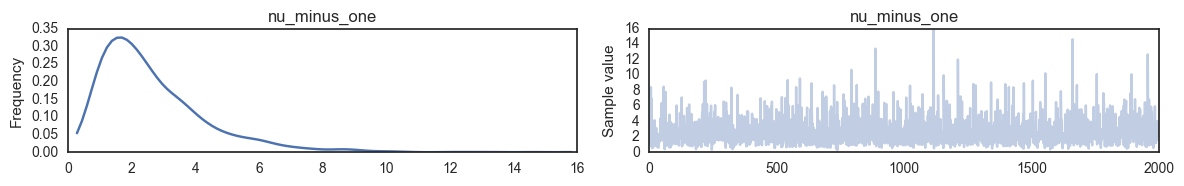

In [10]:
pm.traceplot(trace, varnames=['nu_minus_one'])

In [11]:
trace['nu_minus_one'].mean(axis=0)

2.6713652729300046

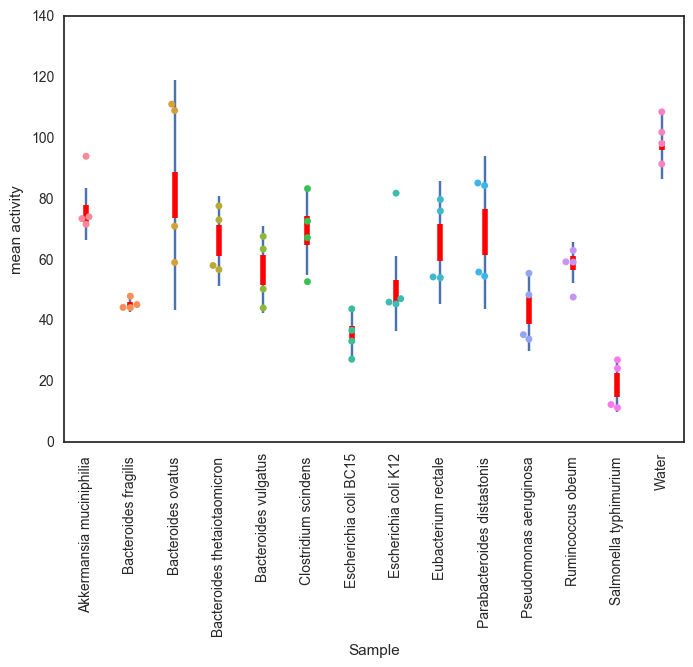

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

# summary_stats[['std', '3sd', 'sem', '95ci', 'range', 'hpd']].plot(ax=ax)

lower, lower_q, upper_q, upper = np.percentile(trace['fold'], [2.5, 25, 75, 97.5], axis=0)
err_low = trace['fold'].mean(axis=0) - lower
err_high = upper - trace['fold'].mean(axis=0)
iqr_low = trace['fold'].mean(axis=0) - lower_q
iqr_high = upper_q - trace['fold'].mean(axis=0)

summary_stats['mean_bayes'].plot(rot=90, ls='', ax=ax, yerr=[err_low, err_high])
summary_stats['mean_bayes'].plot(rot=90, ls='', ax=ax, yerr=[iqr_low, iqr_high], elinewidth=4, color='red')
sns.swarmplot(data=data, x='Sample', y='Normalized % GFP', orient='v', ax=ax)
# sns.violinplot(data=trace_df, ax=ax)
plt.xticks(rotation='vertical')
plt.ylabel('mean activity')

In [14]:
pm.df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
upper,101.720875,1.677322,0.035305,98.387530,104.947552
nu_minus_one,2.671365,1.736646,0.037679,0.453682,6.101345
fold__0,75.096961,4.227646,0.098614,66.984757,82.972798
fold__1,45.112830,1.279119,0.027216,42.384246,47.439451
fold__2,81.225555,14.874203,0.302643,50.660221,102.017844
fold__3,66.252366,7.221430,0.152521,52.592839,80.353123
fold__4,56.657161,7.310657,0.168826,42.292298,70.382306
fold__5,69.650379,7.078854,0.147734,54.999719,81.866000
fold__6,35.363523,4.071117,0.086424,27.796485,43.910044
fold__7,49.015819,6.109781,0.120094,37.379029,61.563900


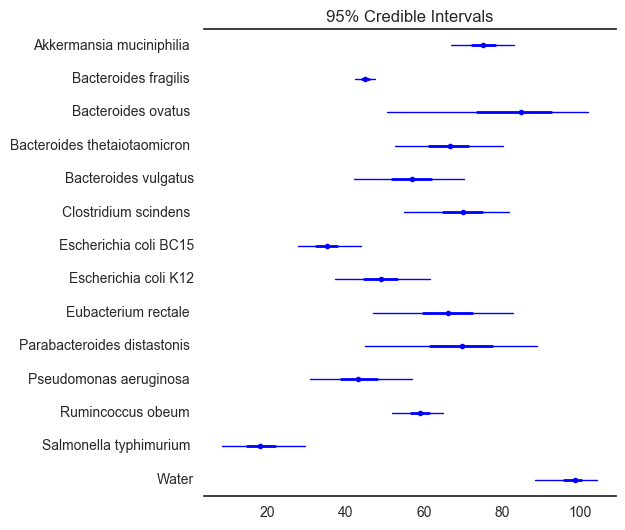

In [15]:
pm.forestplot(trace, varnames=['fold'], ylabels=sorted(sample_names.keys()))

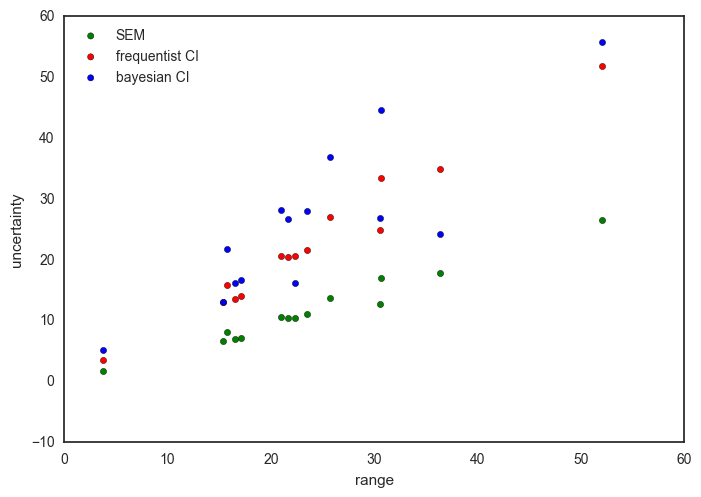

In [16]:
ax = summary_stats.plot(kind='scatter', x='range', y='sem', color='green', label='SEM')
summary_stats.plot(kind='scatter', x='range', y='95ci', ax=ax, color='red', label='frequentist CI', legend=True)
summary_stats.plot(kind='scatter', x='range', y='hpd', ax=ax, color='blue', label='bayesian CI', legend=True)
ax.legend(loc='upper left')
plt.ylabel('uncertainty')

In [17]:
data[data['Sample'] == 'Escherichia coli K12']

,Date,Sample,% GFP,Normalized % GFP,Replicate,Indices
28,08.31.2016,Escherichia coli K12,19.60,81.837161,4,7
29,09.03.2016,Escherichia coli K12,7.36,45.432099,2,7
30,09.03.2016,Escherichia coli K12,7.46,46.049383,1,7
31,08.31.2016,Escherichia coli K12,11.30,47.181628,3,7


We can use Dixon's Q-test to see whether there's an outlier here.

In [18]:
outlier_test_data = data[data['Sample'] == 'Escherichia coli K12']['Normalized % GFP'].values
outlier_test_data

array([ 81.83716075,  45.43209877,  46.04938272,  47.18162839])

In [19]:
largest = sorted(outlier_test_data)[-1]
second_largest = sorted(outlier_test_data)[-2]
smallest = sorted(outlier_test_data)[0]

gap = largest - second_largest
data_range = largest - smallest

gap / data_range

0.9519426825598829

By Dixon's Q-test table, 0.95 is greater than the 0.829 cut-off for sample size = 4 and 95% confidence. The value of 81.8 is likely a statistical outlier.

Yet, we had to be careful here. The Q-test should be applied sparingly, and only once per set of measurements. By going Bayesian with the likelihood function for the data being t-distributed, the Bayesian estimation procedure automatically recognizes this data as a probable outlier, and the estimated HPD is considerably smaller than the data range.

If we changed the likelihood function to a Normal distribution, our 95% HPDs would be identical to the 95% confidence intervals, but the assumption of normality has problems because it assumes infinite degrees of freedom in measurement, whereas with only `n=4`, the number of degrees of freedom is only 3.

# Assumptions

1. **i.i.d. (independent & identically distributed)**: The measurement of one sample doesn't affect the measurement of another sample (e.g. for E. coli), and they are assumed to have come from the same distribution family.
1. The distributions are symmetrical. The t-test assumes t-shaped data.

# Bayesian Coefficients

When the samples are i.i.d., it is possible to calculate Bayesian coefficients of measurement, such as effect sizes, Z-factors (for HT experiments) and the likes. Canonically, these are computed as point estimates, with no notion of uncertainty associated with them.

In the model specification, this was done with the following code:

```python

# Create masked array for all indices except for the control.
sample_indices = np.ma.array(np.unique(data['Indices']), mask=False)
sample_indices.mask[[sample_indices == baseline_idx]] = True
sample_indices = sample_indices.compressed()

diffs = pm.Deterministic('diffs', fold[sample_indices] - fold[baseline_idx])
s_pooled = pm.Deterministic('s_pooled', np.sqrt((sigma[sample_indices] ** 2 + sigma[baseline_idx] ** 2) / 2))
effect_size = pm.Deterministic('effect_size', diffs / s_pooled)

z_factor = pm.Deterministic('z_factor', 1 - (3 * sigma[indices, :] + 3 * sigma[baseline_idx]) / np.abs(fold[indices, :] - fold[baseline_idx]))

```

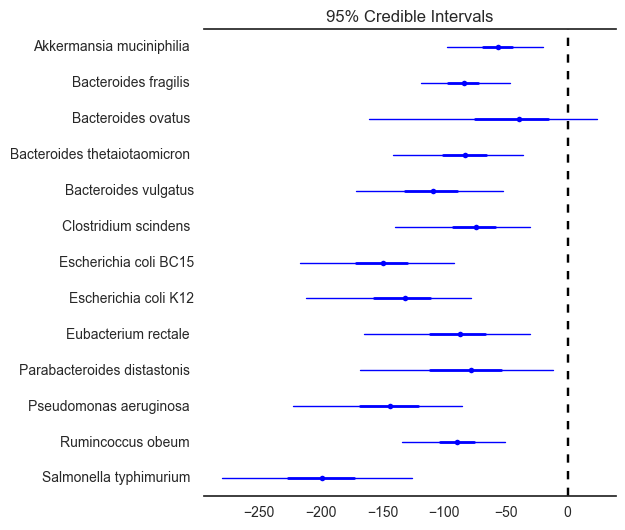

In [20]:
sample_names_without_water = sorted(sample_names.keys())
sample_names_without_water.remove('Water')
pm.forestplot(trace, varnames=['effect_size'], ylabels=sample_names_without_water)

Need more information on Cohen's d? Check it out [here](http://rpsychologist.com/d3/cohend/).

# Reporting Results

Which would be the best?

**bad**

> our results showed a significant difference between treatment and control 

**irrelevant**

> our results showed that the treatment exhibited 220% the activity level of the control (p < 0.05)

**good**

> our results showed that the treatment exhibited 220% the activity level of the control (cohen's d: 2.5)

**uncertainty!**

> our results showed that the treatment exhibited (220 ± 37%) the activity level of the control (100 ± 15%) (cohen's d: 2.5)

**clarity!!**

> our results showed that the treatment exhibited 220% (HPD: 183, 257) the activity level of the control at 100% (HPD: 85, 115).

# Bayesian Advantages

1. No need for outlier test. Use Student's T distribution to "account for" outliers automatically.
1. There's no convoluted interpretation of the HPD credible interval. It is directly related to the probability of the true parameter value being estimated.
1. We have a measure of uncertainty for computed experimental coefficients, e.g. Z-factors and effect sizes.

# Things Bayesian-ism Doesn't Solve

1. Randomly occurring outliers.

# Application to HT Measurement

1. Assumption of i.i.d. measurements holds.
1. Each genotype's μ and σ are independent of other genotype's μ and σ.
1. Each genotype's μ and σ can be assumed to be drawn from a "master" distribution.
1. More sophisticated model: batch effects.